# Transport patterns between curves
The goal of this notebook is to visualize transport patterns between
curves; it appears that the linear program may be the bottleneck of
the implementation, so we're going to see if we can write a more efficient
implementation here.

First, we'll define some curves.

In [1]:
# imports
import numpy as np
import numpy.linalg as la
import scipy.optimize as op
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

%load_ext line_profiler
%matplotlib inline

## Define (and plot) the line segments

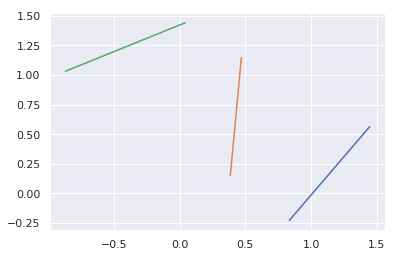

In [61]:
def line_segment(start, vec, seglen, n_pts):
    p0 = np.array(start)
    v = np.array(vec)
    v = v / la.norm(v) * seglen / n_pts
    return np.array([p0+k*v for k in range(n_pts+1)])

def random_uniform_direction():
    theta = np.random.uniform(0, 2*np.pi)
    return [np.cos(theta), np.sin(theta)]

N_DIV = 15
N_CURVE = 3
RMAX = 2.
curves = [
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1),
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1),
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1)
]
#curves = [
#    line_segment((0,1), 
#                 (0.001,1), 1, N_DIV-1),
#    line_segment((1,0), 
#                 (1,0), 1, N_DIV-1),
#    line_segment((2,3), 
#                 (1,-1), 1, N_DIV-1)
#]

for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
plt.show()

## Geometric median function

In [56]:
# Geometric median
import numpy as np
from scipy.spatial.distance import cdist, euclidean
import numpy.linalg as la

def geometric_median(X, eps=1e-5, max_iter=1000):
    y = np.mean(X, 0)

    for _ in range(max_iter):
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1
    return y

th60 = np.radians(60)
c60, s60 = np.cos(th60), np.sin(th60)
rot60 = np.array([[c60,-s60],[s60,c60]])
rotN60 = np.array([[c60,s60],[-s60,c60]])

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def get_intersect_many(s):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    #s = np.vstack([a1,a2,b1,b2])        # s for stacked
    #print(s.shape)
    h = np.concatenate((s, np.ones((s.shape[0], 4, 1))), axis=2) # h for homogeneous
    #print(h.shape)
    
    l1 = np.cross(h[:,0], h[:,1])           # get first line
    l2 = np.cross(h[:,2], h[:,3])           # get second line
    x, y, z = np.cross(l1, l2).T          # point of intersection
#    if z == 0:                          # lines are parallel
#        return (float('inf'), float('inf'))
    return np.array((x/z, y/z))

def geometric_median_3(X, **kwargs):
    """Use geometry to compute fast explicit GM of 3 points"""
    A,B,C = X
    
    ABvec = B-A
    ACvec = C-A
    if (np.arctan2(ACvec[1], ACvec[0]) - np.arctan2(ABvec[1], ABvec[0])) > 0:
        B,C = C,B
        ABvec = B-A
        ACvec = C-A
    
    ARvec = rot60 @ ABvec
    R = X[0]+ARvec
    
    AQvec = rotN60 @ ACvec
    Q = X[0]+AQvec
    
    P = get_intersect(R,X[2],Q,X[1])
    
    S = [A,B,C,P]
    d = [sum(la.norm(z-fp) for z in X) for fp in S]
    
    return S[np.argmin(d)]
    

## Set up the linear program

In [57]:
#%%timeit

N = len(curves[0])

ABmtx = np.zeros([N,N,2])
import itertools

for (ai, a), (bi, b) in itertools.product(enumerate(curves[0]), enumerate(curves[1])):
    ABmtx[ai,bi,:] = b-a
    
ARmtx = np.tensordot(ABmtx, rot60, (2,1))

ACmtx = np.zeros([N,N,2])

for (ai, a), (ci, c) in itertools.product(enumerate(curves[0]), enumerate(curves[2])):
    ACmtx[ai,ci,:] = c-a
    
AQmtx = np.tensordot(ACmtx, rotN60, (2,1))

Betamtx = np.arctan2(ACmtx[:,:,1],ACmtx[:,:,0])
Gammamtx = np.arctan2(ABmtx[:,:,1],ABmtx[:,:,0])

In [58]:
#%%timeit

def f():
# Specific 3-group case
    groups = []
    for i0, A in enumerate(curves[0]):    
        for i1, B in enumerate(curves[1]):
            #ABvec = B-A
            ABvec = ABmtx[i0,i1]
            #ARvec = rot60 @ ABvec
            ARvec = ARmtx[i0,i1]
            
            batch = np.zeros((len(curves[2]), 4, 2))

            for i2, C in enumerate(curves[2]):
                #ACvec = C-A
                ACvec = ACmtx[i0,i2]
                #AQvec = rotN60 @ ACvec
                AQvec = ACmtx[i0,i2]

                #tan_phi = np.arctan2(ACvec[1], ACvec[0]) - np.arctan2(ABvec[1], ABvec[0]) 
                tan_phi = Betamtx[i0,i2] - Gammamtx[i0,i1]
                #tan_phi = Phimtx[i0,i1,i2]
                if (tan_phi) < 0:
                    R = A + ARvec
                    Q = A + AQvec
                else:      
                    R = B - ARvec
                    Q = C - AQvec

                batch[i2] = np.array([R,C,Q,B])
                
            Pvec = get_intersect_many(batch).T
            #print(Pvec.shape)
            
            Sb = np.zeros((batch.shape[0], 4, 2))
            Sb[:,0] = A
            Sb[:,1] = B
            Sb[:,2] = batch[:,1]
            
            Zb = Sb[:,0:3,:]
            
            Evec = np.sum(
                la.norm(Sb[:,:,np.newaxis]-Zb[:,np.newaxis], axis=3),
                axis=2
            )
            
            minvec = np.argmin(Evec, axis=1)
            
            for i2, ((R,C,Q,B), P, S, energy, m_i) in enumerate(zip(batch, Pvec, Sb, Evec, minvec)):

                groups.append({
                    'index': [i0, i1, i2],
                    'points': np.array([A,B,C]),
                    'median': S[m_i],
                    'energy': energy[m_i],
                })


In [59]:
Sb = np.random.normal(size=(20, 4, 2))
Zb = Sb[:,0:3,:]

np.argmin(np.sum(la.norm(Sb[:,:,np.newaxis] + Zb[:,np.newaxis], axis=3), axis=2),axis=1)

array([0, 1, 3, 3, 0, 2, 3, 2, 3, 3, 0, 0, 0, 2, 0, 0, 1, 3, 3, 3])

In [60]:
%lprun -f f -f get_intersect_many f()

Timer unit: 1e-06 s

Total time: 2.78353 s
File: <ipython-input-56-e66221ca1925>
Function: get_intersect_many at line 57

Line #      Hits         Time  Per Hit   % Time  Line Contents
    57                                           def get_intersect_many(s):
    58                                               """ 
    59                                               Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    60                                               a1: [x, y] a point on the first line
    61                                               a2: [x, y] another point on the first line
    62                                               b1: [x, y] a point on the second line
    63                                               b2: [x, y] another point on the second line
    64                                               """
    65                                               #s = np.vstack([a1,a2,b1,b2])        # s for stacked
    66     

Initial implementation runtime was

     11.7 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
After adding a few preprocess steps new time is...

     11.6 s ± 50.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
No on-the-fly arctan gives...

     11.3 s ± 66.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
Preprocess rotate gives...

     11.2 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     


In [65]:
medians = np.array([g['median'] for g in groups])

We now move on to setting up (and solving) the linear program proper. Scipy's linprog uses the following form for linear programs. We are solving for \\(x\\) which minimizes
\\[ c^T x \\]
while satisfying the constraints
\\[ A_{ub} x \le b_{ub}, \quad A_{eq} x = b_{eq}, \quad l \le x \le u \\]

In our case, the cost we're minimizing is the linear combination of total median distances

In [66]:
# group energies (c-vector)
energies = np.array([g['energy'] for g in groups])

In [67]:
def _idxs(index):
    return [i*N_DIV+j for i,j in enumerate(index)]

import scipy.sparse as sparse

# equality constraints
A_eq = sparse.dok_matrix((N_DIV*N_CURVE, len(energies)))
for i,g in enumerate(groups):
    A_eq[_idxs(g['index']), i] = 1.
    
# transport quantities are all 1 for uniform problem
b_eq = np.ones(A_eq.shape[0])

In [68]:
A_eq.shape

(120, 64000)

In [69]:
from scipy.optimize import linprog
soln = linprog(energies, A_eq=A_eq, b_eq=b_eq, method='interior-point')

In [70]:
import pandas as pd
solution = pd.DataFrame([
    {'weight': x, 
     'median_x': group['median'][0], 
     'median_y': group['median'][1],
     't_0': group['index'][0],
     't_1': group['index'][1],
     't_2': group['index'][2]} for 
    x,group in zip(soln['x'], groups)])

print(len(solution[solution['weight'] > 0.001]), "median points")
solution[solution['weight'] > 0.001].sort_values('t_2')

40 median points


,median_x,median_y,t_0,t_1,t_2,weight
54120,0.357445,1.469566,33,33,0,1.0
55761,0.334885,1.481753,34,34,1,1.0
57402,0.312325,1.493940,35,35,2,1.0
52483,0.380004,1.457379,32,32,3,1.0
59044,0.289765,1.506127,36,36,4,1.0
50845,0.402564,1.445193,31,31,5,1.0
60686,0.267205,1.518313,37,37,6,1.0
49207,0.425124,1.433006,30,30,7,1.0
62328,0.244646,1.530500,38,38,8,1.0
63969,0.222086,1.542687,39,39,9,1.0


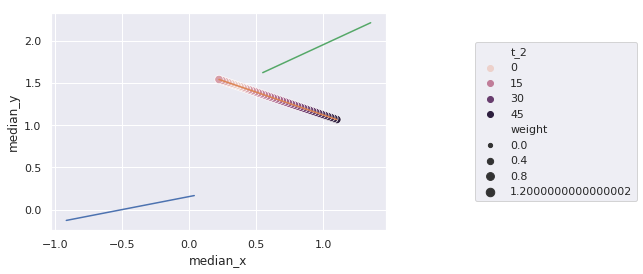

In [71]:
for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
    
g = sns.scatterplot(data=solution[solution['weight'] > 1e-3], 
                x='median_x', y='median_y',
                hue='t_2', size='weight', size_norm=(0,1))
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

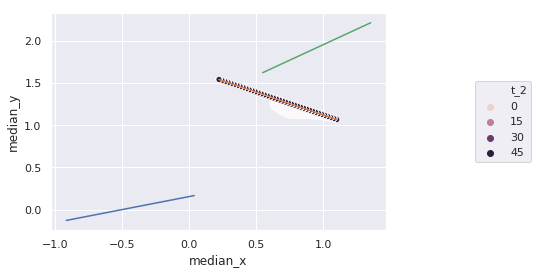

In [60]:
for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
    
g = sns.scatterplot(data=solution, 
                x='median_x', y='median_y',
                hue='t_2')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

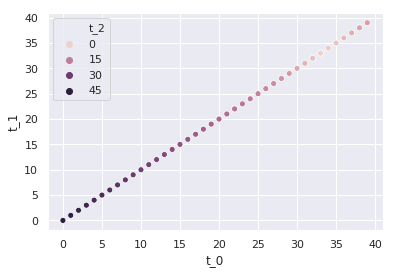

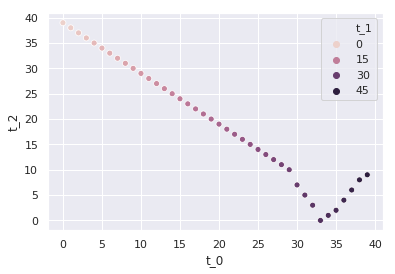

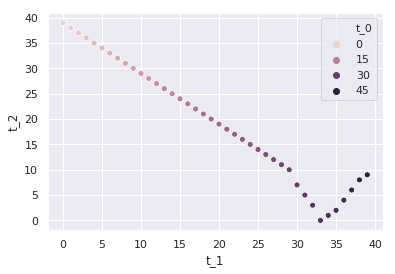

In [50]:
import itertools

sets = ['t_0', 't_1', 't_2']

for x,y,z in [['t_0', 't_1', 't_2'], ['t_0', 't_2', 't_1'], ['t_1', 't_2', 't_0']]:
    sns.scatterplot(data=solution[solution['weight'] > 1e-3], x=x, y=y, hue=z)
    plt.show()

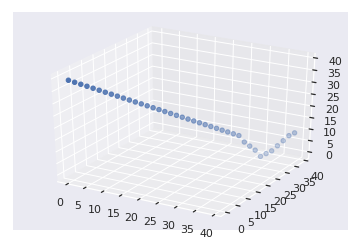

In [51]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

psol = solution[solution['weight'] > 1e-3]
ax.scatter(psol['t_0'], psol['t_1'], psol['t_2'])

fig.show()